# Introduction

* Time series volatility models, such as GARCH (Generalized Autoregressive Conditional Heteroskedasticity) and ARCH (Autoregressive Conditional Heteroskedasticity) models, work by estimating the conditional variance of a financial time series.

* The basic idea behind these models is that volatility tends to cluster together in time, meaning that periods of high volatility are likely to be followed by periods of high volatility, and periods of low volatility are likely to be followed by periods of low volatility. By modeling the conditional variance of the time series, these models attempt to capture these volatility patterns.

* Recent literature has shown that if we combine ml model with GARCH models we can attain better accuracy for variance.

* in this notebook we will use Support vectoe regression with Garch to forcast volatilty 

* We use the parcentage change in returns and realised volatility as the independent varriables and we use the variance forecast from the Garch model for our predictions

In [127]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', 150, 'display.max_rows', 100, 'display.max_colwidth', 15)
%matplotlib inline
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

## Load Data for stocks
for S&P 500 stocks from 01-01-2010 to 01-08-2021

In [128]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')
#s_p500.index= pd.to_datetime(s_p500.index, format= "%Y-%m-%d").date
s_p500.index

[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2010-01-04 00:00:00-05:00', '2010-01-05 00:00:00-05:00',
               '2010-01-06 00:00:00-05:00', '2010-01-07 00:00:00-05:00',
               '2010-01-08 00:00:00-05:00', '2010-01-11 00:00:00-05:00',
               '2010-01-12 00:00:00-05:00', '2010-01-13 00:00:00-05:00',
               '2010-01-14 00:00:00-05:00', '2010-01-15 00:00:00-05:00',
               ...
               '2021-07-19 00:00:00-04:00', '2021-07-20 00:00:00-04:00',
               '2021-07-21 00:00:00-04:00', '2021-07-22 00:00:00-04:00',
               '2021-07-23 00:00:00-04:00', '2021-07-26 00:00:00-04:00',
               '2021-07-27 00:00:00-04:00', '2021-07-28 00:00:00-04:00',
               '2021-07-29 00:00:00-04:00', '2021-07-30 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=2914, freq=None)

In [129]:
s_p500.index.names = ['Date']

In [130]:
s_p500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2021-07-26 00:00:00-04:00,4409.580078,4422.729980,4405.450195,4422.299805,4422.299805,4275630000
2021-07-27 00:00:00-04:00,4416.379883,4416.379883,4372.509766,4401.459961,4401.459961,4241950000
2021-07-28 00:00:00-04:00,4402.950195,4415.470215,4387.009766,4400.640137,4400.640137,4215290000


In [131]:
s_p500.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## rename all columns to lower letters and remove spaces

In [132]:
s_p500.columns =  [x.lower().replace(" ", "") for x in s_p500.columns]
s_p500

,open,high,low,close,adjclose,volume
Date,,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2021-07-26 00:00:00-04:00,4409.580078,4422.729980,4405.450195,4422.299805,4422.299805,4275630000
2021-07-27 00:00:00-04:00,4416.379883,4416.379883,4372.509766,4401.459961,4401.459961,4241950000
2021-07-28 00:00:00-04:00,4402.950195,4415.470215,4387.009766,4400.640137,4400.640137,4215290000


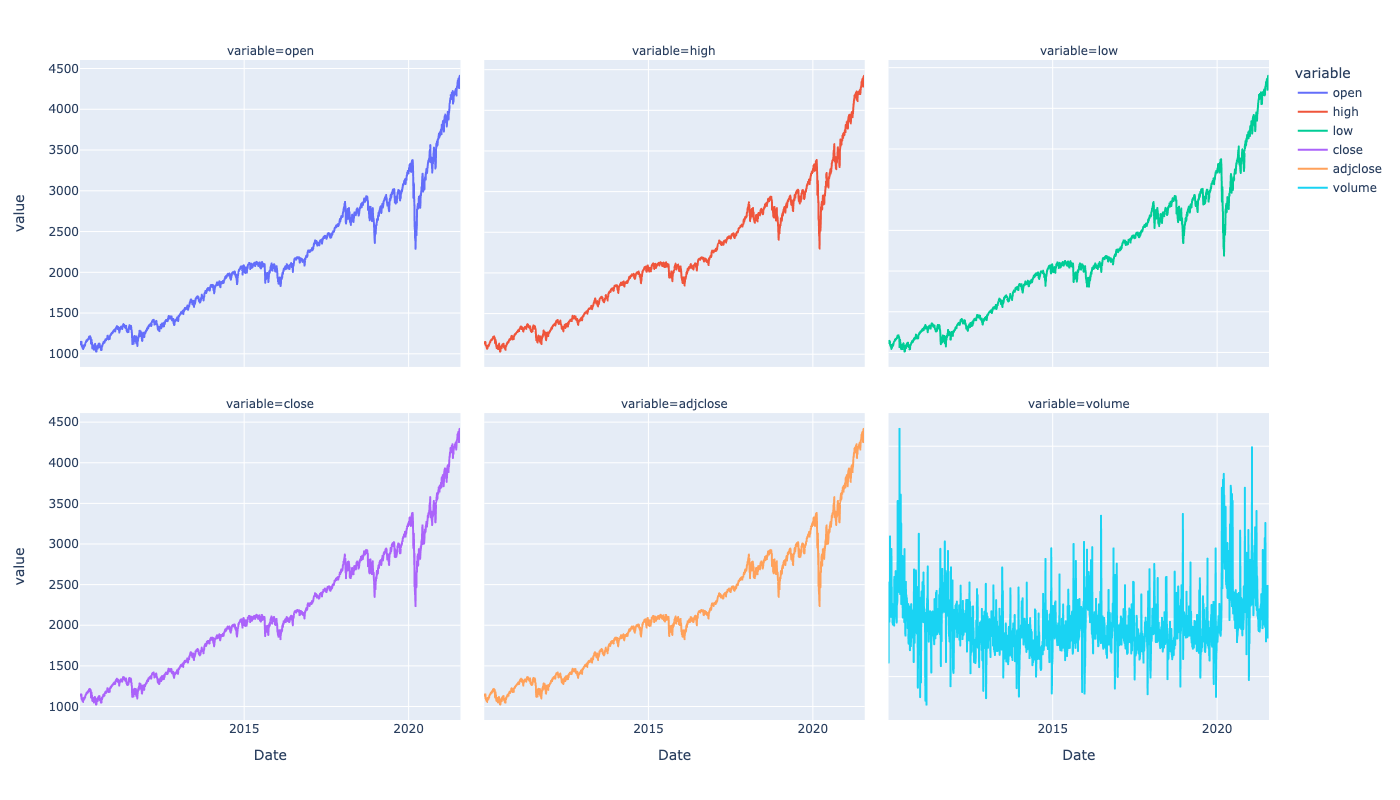

In [133]:
(
    s_p500
    .reset_index()
    .melt(id_vars= "Date")
    .plot.line(
    x= "Date" ,y= "value",
    facet_col= "variable",
    facet_col_wrap= 3, 
    color= "variable", 
    height= 800, width= 1400)
    .update_yaxes(matches=None) 
       
    ).show("png")

Take percentage change, which is the change in value today compared to yesterday. 

We can change the number to 2, 3, 4 if we want to take percentage change comapred to more than one day ago

## Calculate returns based on adjclose price

we take percentage change from previous value compared to todays values as returns (ret)

difference between yesterday and todays values will be gains or losses.


In [134]:
ret = s_p500.assign(returns=100 * (s_p500.pct_change()[['adjclose']]))[["returns"]].iloc[1:]
ret

,returns
Date,
2010-01-05 00:00:00-05:00,0.311568
2010-01-06 00:00:00-05:00,0.054552
2010-01-07 00:00:00-05:00,0.400120
2010-01-08 00:00:00-05:00,0.288173
2010-01-11 00:00:00-05:00,0.174676
...,...
2021-07-26 00:00:00-04:00,0.238220
2021-07-27 00:00:00-04:00,-0.471244
2021-07-28 00:00:00-04:00,-0.018626


To gauge the extent to which proposed models account for the real-world situation, we need to calculate the return volatility, which is also known as realized volatility.

Realized volatility is the square root of realized variance (standard deviation), which is the sum of squared returns.

Realized volatility is used to calculate the performance of the volatility prediction method. Here is the formula for return volatility:

$$\sigma = \sqrt{\frac{1}{n-1} \sum_{n=1}^{N} (r_n - \mu)^2}$$

where $\sigma$ is the return volatility, $n$ is the number of returns, $N$ is the total number of returns, $r_n$ is the return at time $n$, and $\mu$ is the mean return.

By using this formula, we can measure the volatility of returns over a given period, and use it to compare the performance of different volatility models.

We calculate volatility over the period of 5, as rolling std deviation of 5 window.

## Create Realized Volatility

In [135]:
ret= ret.assign(
    realized_vol= ret.returns.rolling(2).std(),
                ).dropna()
ret.head()

,returns,realized_vol
Date,,
2010-01-06 00:00:00-05:00,0.054552,0.181737
2010-01-07 00:00:00-05:00,0.400120,0.244354
2010-01-08 00:00:00-05:00,0.288173,0.079159
2010-01-11 00:00:00-05:00,0.174676,0.080255
2010-01-12 00:00:00-05:00,-0.938117,0.786863


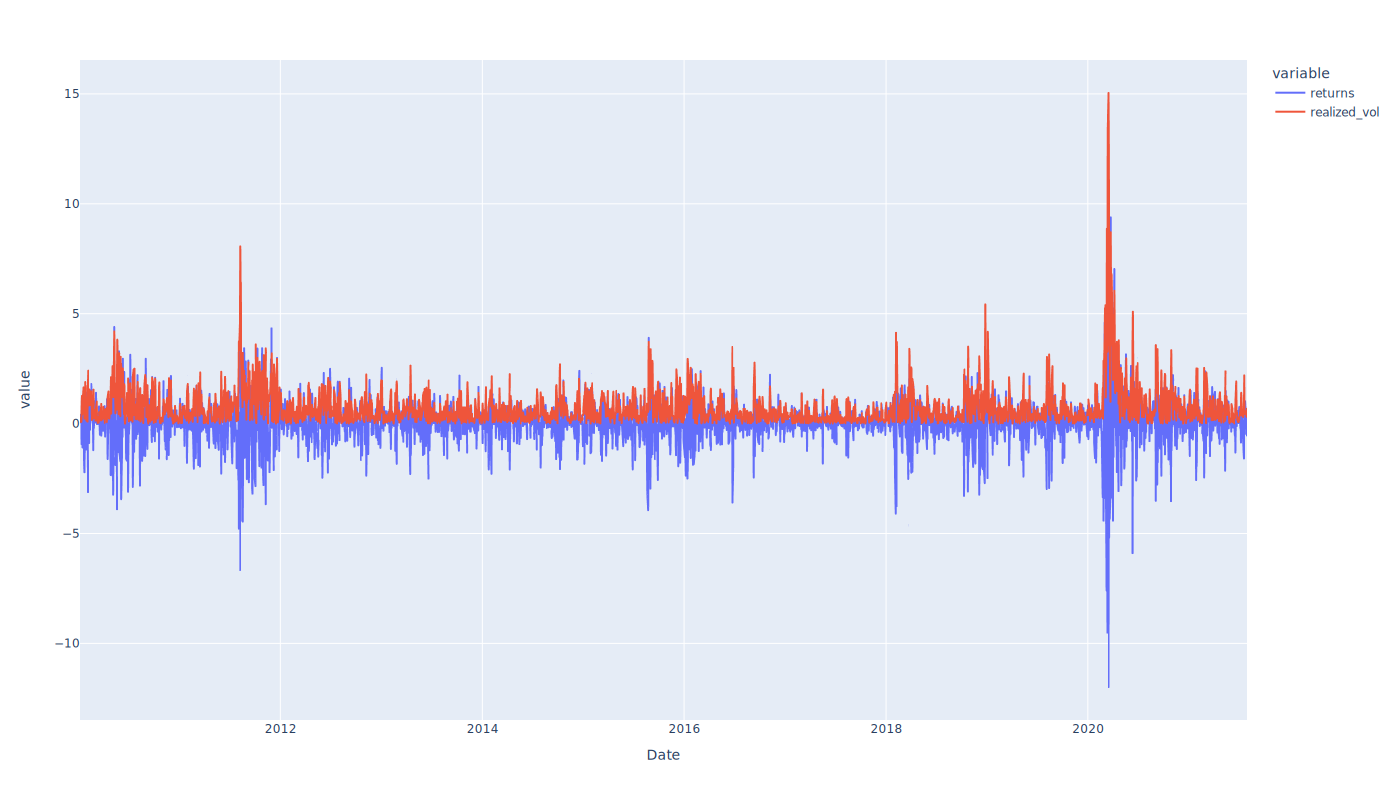

In [136]:
(
    ret
    # .reset_index()
    # .melt(id_vars = "Date")
    .plot(
    # x= "Date", y= "value", 
    # facet_row = "variable", color="variable" ,
    height= 800,
    width= 1400
    )
).show("svg")

## ACF- PACF plots
Our series is an MA(1) process and AR(1) process as autocorrelation plot shows not significance lag after 1 and and same for pacf plot

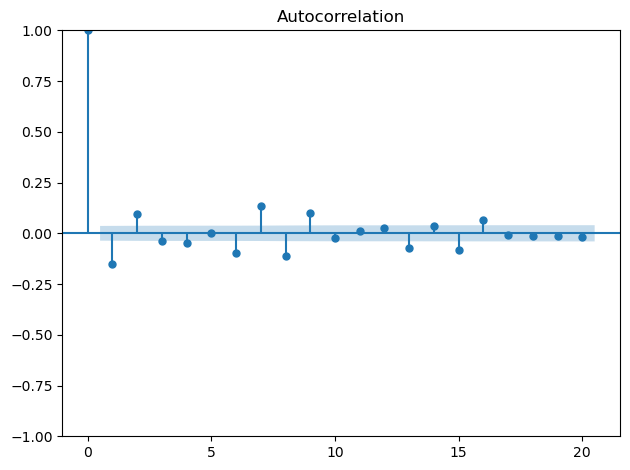

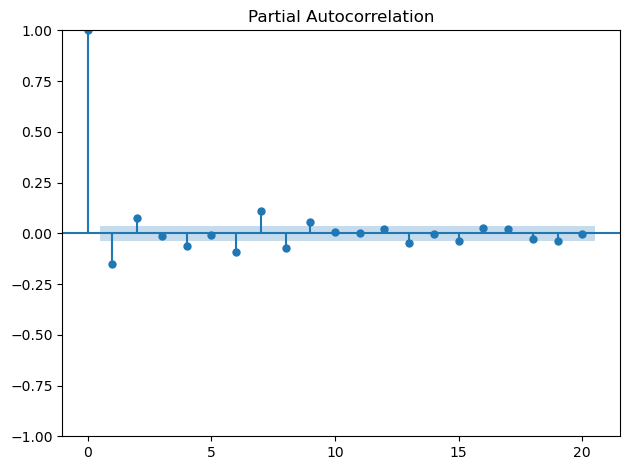

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ret.returns , lags=20)
plt.tight_layout()
plot_pacf(ret.returns, lags=20)
plt.tight_layout()

In [138]:
n = 252
split_date = ret.iloc[-n:].index
split_date

DatetimeIndex(['2020-07-31 00:00:00-04:00', '2020-08-03 00:00:00-04:00',
               '2020-08-04 00:00:00-04:00', '2020-08-05 00:00:00-04:00',
               '2020-08-06 00:00:00-04:00', '2020-08-07 00:00:00-04:00',
               '2020-08-10 00:00:00-04:00', '2020-08-11 00:00:00-04:00',
               '2020-08-12 00:00:00-04:00', '2020-08-13 00:00:00-04:00',
               ...
               '2021-07-19 00:00:00-04:00', '2021-07-20 00:00:00-04:00',
               '2021-07-21 00:00:00-04:00', '2021-07-22 00:00:00-04:00',
               '2021-07-23 00:00:00-04:00', '2021-07-26 00:00:00-04:00',
               '2021-07-27 00:00:00-04:00', '2021-07-28 00:00:00-04:00',
               '2021-07-29 00:00:00-04:00', '2021-07-30 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=252, freq=None)

## Data Split
We we forecast volattility for 252 days in the future and seperate the train and test set accordingly

In [139]:
n = 252
split_date = ret.iloc[-n:].index
split_date

DatetimeIndex(['2020-07-31 00:00:00-04:00', '2020-08-03 00:00:00-04:00',
               '2020-08-04 00:00:00-04:00', '2020-08-05 00:00:00-04:00',
               '2020-08-06 00:00:00-04:00', '2020-08-07 00:00:00-04:00',
               '2020-08-10 00:00:00-04:00', '2020-08-11 00:00:00-04:00',
               '2020-08-12 00:00:00-04:00', '2020-08-13 00:00:00-04:00',
               ...
               '2021-07-19 00:00:00-04:00', '2021-07-20 00:00:00-04:00',
               '2021-07-21 00:00:00-04:00', '2021-07-22 00:00:00-04:00',
               '2021-07-23 00:00:00-04:00', '2021-07-26 00:00:00-04:00',
               '2021-07-27 00:00:00-04:00', '2021-07-28 00:00:00-04:00',
               '2021-07-29 00:00:00-04:00', '2021-07-30 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=252, freq=None)

In [140]:
X_train= ret.iloc[:-n]
X_train

,returns,realized_vol
Date,,
2010-01-06 00:00:00-05:00,0.054552,0.181737
2010-01-07 00:00:00-05:00,0.400120,0.244354
2010-01-08 00:00:00-05:00,0.288173,0.079159
2010-01-11 00:00:00-05:00,0.174676,0.080255
2010-01-12 00:00:00-05:00,-0.938117,0.786863
...,...,...
2020-07-24 00:00:00-04:00,-0.619040,0.433418
2020-07-27 00:00:00-04:00,0.739514,0.960643
2020-07-28 00:00:00-04:00,-0.647339,0.980653


In [141]:
y_test_original= ret.realized_vol.iloc[-n:]
y_test_original

Date
2020-07-31 00:00:00-04:00    0.807569
2020-08-03 00:00:00-04:00    0.034612
2020-08-04 00:00:00-04:00    0.252373
2020-08-05 00:00:00-04:00    0.199249
2020-08-06 00:00:00-04:00    0.000145
                               ...   
2021-07-26 00:00:00-04:00    0.548945
2021-07-27 00:00:00-04:00    0.501667
2021-07-28 00:00:00-04:00    0.320049
2021-07-29 00:00:00-04:00    0.310591
2021-07-30 00:00:00-04:00    0.679685
Name: realized_vol, Length: 252, dtype: float64

## Def Functions

### Evaluation Function

In [142]:
def eval_rmse(x,y):
    result = np.sqrt(mse(x/100, np.sqrt(y/100)))
    return result

### Plot Function

In [143]:
def plot_forecat(x):
    p=( ret.reset_index()[ret.reset_index().Date > pd.to_datetime('2017-01-01 00:00:00-04:00') ]
        .plot.line(x="Date", y= "realized_vol", title= x +' Realized Volatility',color_discrete_sequence=['blue'],width=1200, height= 600)    
        .add_scatter(x=frcts_values.index, y = frcts_values["value"],mode="lines",line=dict(width= 2, color="red"),name= "forecast")    
    )
    return p.show("png")

### Rolling Forecast Function
* In real world scenario we need only 1-2 days of valatility forecast. the function below creates a rolling volatility forecast for one step at a time and produces 
252 models and forecats for each type of model.
* We can also create a forecast directly for next 252 days but it will not be very accurate and it will be based on the coefficents uptill the last point.

In [144]:
def rolling_forecast(y_test_original,vol, p=0, q=0, o=0 ):
    rolling_predictions = []
    dates=[]
    for i in range(y_test_original.shape[0]):
        train = ret.returns[:-(y_test_original.shape[0] -i)]    
        if vol == "None":
            model = arch_model(train, mean='zero', p=p, q=q, o=o)
        else:
            model = arch_model(train, mean='zero', vol= vol, p=p, q=q, o=0)
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        dates.append(train.index[-1])
        rolling_predictions.append(
            #np.sqrt(
            pred.variance.values[-1,:][0]
            #)
            )
    frcts_values= pd.DataFrame(rolling_predictions, columns= ["value"], index= dates)
    return frcts_values
 


## Generalised conditional hetroskadestic model (GARCH models)

it is possible to model higher order ARCH models. However, these models are difficult to estimate for higher orders of lag since they often produce negative estimates of the $\alpha s$.

To solve this problem, people have turned to the GARCH model (Bollerslev 1986).

Essentially, the GARCH model turns the AR process of the ARCH model into an ARMA process by adding in a moving average process. In the GARCH model, the conditional disturbance variance is now

$\sigma^2_t = \alpha_0 + \alpha_1\epsilon^2_{t-1} + \cdots + \alpha_p\epsilon^ 2_{t-p} + \gamma_1\sigma^2_{t-1} + \gamma_2\sigma^2_{t-2} + \cdots + \gamma_q\sigma^2_{t-q}$

$\sigma^2_t = \alpha_0 + \sum_{j=1}^{p} \alpha_j \epsilon^2_{t-j} + \sum_{k=1}^{q} \gamma_k \sigma^2_{t-k} \qquad\qquad\qquad(1)$


### GARCH Model

selecting the ARMA order is using Bayesian information criteria we can loop the p and q order and selection the model with minimum bic value

### Next 252 Days Forecats

In [145]:
bic_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        model = arch_model(X_train.returns, mean='zero',vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(model.bic)
        if model.bic == np.min(bic_garch):
            best_param = p, q
            print(best_param)                   
model = arch_model(X_train.returns, mean='constant', vol='GARCH',p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
print(model.summary())

forecast= model.forecast(horizon= n)
frcts_values= np.sqrt(forecast.variance.iloc[-1:].melt().drop(columns="variable"))
frcts_values.index= y_test_original.index

(1, 1)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3299.84
Distribution:                  Normal   AIC:                           6607.69
Method:            Maximum Likelihood   BIC:                           6631.23
                                        No. Observations:                 2660
Date:                Fri, Mar 10 2023   Df Residuals:                     2659
Time:                        10:28:27   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0830  1.386e-02      5.993  2.059e-09 [5

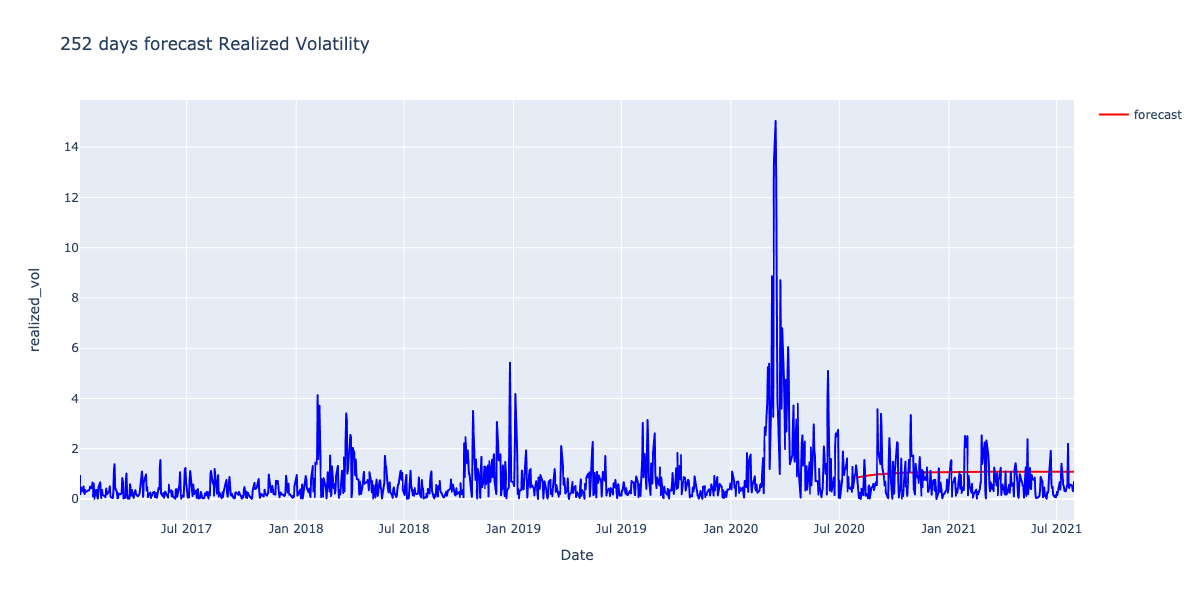

In [146]:
plot_forecat("252 days forecast")

### Garch Rolling Forecast

In [147]:
frcts_values= rolling_forecast(y_test_original, "GARCH", p=1, q=1 )
rmse =  eval_rmse(y_test_original, frcts_values)
df_resuts= pd.DataFrame({ "model" :  ["Garch_rolling"] , "results" : [rmse]}, index= [0] )
df_resuts

,model,results
0,Garch_rolling,0.089656


## Support Vector regression Garch (SVR-GARCH)

### Lets create our variables.

* Our independent variables will be return square and realised volatility.
* we can calculate the retuns (percentage change in todays prices vs yesterdays prices) and we can also calculate the realised voaltility (standard deviation over 5 rolling window).
* our target variable will be realised volatility. 
* For test data we will use the forecast of the GARCH model and use it as input to make predictions.

In [148]:
X = (
    ret
    .assign(
    returns= ret.returns ,
    target =  ret.realized_vol#.shift(-1)
    )
    .fillna(ret.realized_vol.mean()) 
    .sort_index()   
    .copy()    
    )
X

,returns,realized_vol,target
Date,,,
2010-01-06 00:00:00-05:00,0.054552,0.181737,0.181737
2010-01-07 00:00:00-05:00,0.400120,0.244354,0.244354
2010-01-08 00:00:00-05:00,0.288173,0.079159,0.079159
2010-01-11 00:00:00-05:00,0.174676,0.080255,0.080255
2010-01-12 00:00:00-05:00,-0.938117,0.786863,0.786863
...,...,...,...
2021-07-26 00:00:00-04:00,0.238220,0.548945,0.548945
2021-07-27 00:00:00-04:00,-0.471244,0.501667,0.501667
2021-07-28 00:00:00-04:00,-0.018626,0.320049,0.320049


In [149]:
X_train= X.iloc[:-n].drop(columns="target")
y_train= X.iloc[:-n]["target"]
X_train.shape, y_train.shape

((2660, 2), (2660,))

In [150]:
model = arch_model(ret.returns , mean='AR', vol='GARCH', p=1, o=0, q=1, lags=1).fit(disp='off')
forecast = model.forecast(start=split_date[0])

X_t= (    
    pd.DataFrame({
    "returns": forecast.mean.iloc[-n:]["h.1"] ,
    "realized_vol": forecast.variance.iloc[-n:]["h.1"]
    })
    .assign(     
     target = lambda df_: df_.realized_vol#.shift(-1)
             )
            .dropna()        
    )
X_t.head()

,returns,realized_vol,target
Date,,,
2020-07-31 00:00:00-04:00,0.041083,0.656624,0.656624
2020-08-03 00:00:00-04:00,0.044297,0.636609,0.636609
2020-08-04 00:00:00-04:00,0.067731,0.553019,0.553019
2020-08-05 00:00:00-04:00,0.049230,0.531882,0.531882
2020-08-06 00:00:00-04:00,0.049243,0.519524,0.519524


In [151]:
X_test_forecast= X_t.drop(columns="target")
y_test_forecast= X_t["target"]
X_test_forecast.shape, y_test_forecast.shape

((252, 2), (252,))

In [152]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand, uniform
from sklearn.model_selection import RandomizedSearchCV

### Define Models

In [153]:
MLA= {
    "svr_lin": SVR(kernel='linear'),
    "svr_rbf": SVR(kernel='rbf') 
    }

In [154]:
from sklearn.model_selection import KFold
cv_split = KFold(n_splits= 10, random_state=10 , shuffle=True)

In [155]:
para_grid = {'gamma': sp_rand() ,
             'C': sp_rand(),
             'epsilon': sp_rand()}

### Random Search CV with parameters

In [156]:
best_model_scores= {}
best_models = {}
for x in MLA.keys():
    reg = RandomizedSearchCV(
        MLA[x], 
        para_grid,
        cv= cv_split,
        n_iter = 100,
        random_state= 421,
        n_jobs= -1    
        )
    reg.fit(X_train, y_train)
    print(f"val. score: {reg.best_score_}  model:{x} "  )    
    best_model_scores[x] = [reg.best_score_]
    best_models[x] = reg.best_params_

val. score: 0.9994819697632158  model:svr_lin 
val. score: 0.9100980157932856  model:svr_rbf 


## Best Parameters

In [157]:
for x in MLA.keys():
    print(best_models[x])

{'C': 0.5269131458007414, 'epsilon': 0.02174361263991509, 'gamma': 0.1541030813214641}
{'C': 0.9884773655240955, 'epsilon': 0.20252222877101977, 'gamma': 0.11106872140751178}


In [158]:
for x in MLA.keys():
    MLA[x].set_params(**best_models[x])
    MLA[x].fit(X_train, y_train)
    print(MLA[x])

SVR(C=0.5269131458007414, epsilon=0.02174361263991509, gamma=0.1541030813214641,
    kernel='linear')
SVR(C=0.9884773655240955, epsilon=0.20252222877101977,
    gamma=0.11106872140751178)


In [159]:
predict_svr_lin = MLA["svr_lin"].predict(X_test_forecast)
frcts_values = pd.DataFrame({"value": predict_svr_lin} )
frcts_values.index = X_test_forecast.index
frcts_values.head()

,value
Date,
2020-07-31 00:00:00-04:00,0.676060
2020-08-03 00:00:00-04:00,0.656107
2020-08-04 00:00:00-04:00,0.572768
2020-08-05 00:00:00-04:00,0.551701
2020-08-06 00:00:00-04:00,0.539381


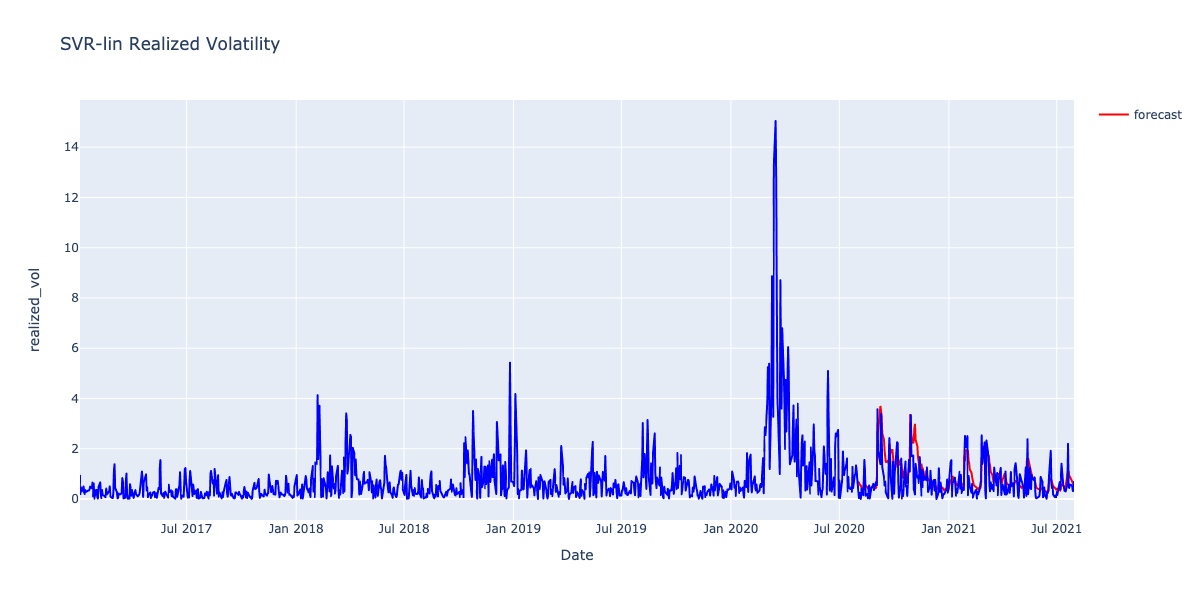

In [160]:
plot_forecat("SVR-lin")

In [161]:
rmse =  eval_rmse(y_test_forecast, frcts_values)
df_resuts.loc[len(df_resuts.index)]= { "model" :  "svr_lin_garch" , "results" :rmse}
df_resuts

,model,results
0,Garch_rolling,0.089656
1,svr_lin_garch,0.086763


### SVR-GARCH RBF

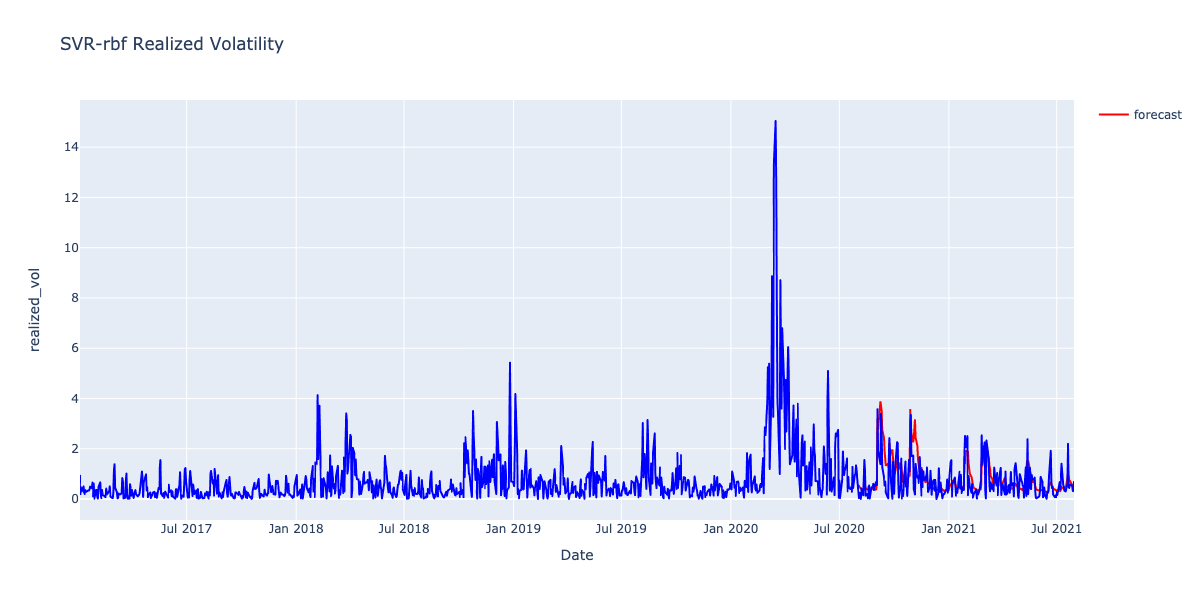

In [162]:
predict_svr_lin = MLA["svr_rbf"].predict(X_test_forecast)
frcts_values = pd.DataFrame({"value": predict_svr_lin} )
frcts_values.index = X_test_forecast.index
frcts_values.head()
plot_forecat("SVR-rbf")

In [163]:
rmse =  eval_rmse(y_test_forecast, frcts_values)
df_resuts.loc[len(df_resuts.index)]= { "model" :  "svr_rbf_garch" , "results" : rmse}


## Results Table

In [164]:
df_resuts.sort_values("results")

,model,results
2,svr_rbf_garch,0.081866
1,svr_lin_garch,0.086763
0,Garch_rolling,0.089656


# Conclusion:
* We estimated volatility using GARCH and SVR-GARCH. 
* We find that SVR-GARCH model out performs GARCH model for volatility testing.